In [1]:
import numpy as np
from qiskit.quantum_info import random_clifford, Pauli

In [2]:
def tensor_prod(*tensors):
    if len(tensors) == 2:
        return np.kron(tensors[0], tensors[1])
    else:
        return np.kron(tensors[0], tensor_prod(*tensors[1:]))
    
def hermitian(matrix):
    return np.allclose(matrix, matrix.conj().T)

def trace_one(matrix):
    return np.isclose(np.trace(matrix), 1)

def positive_semi_definite(matrix, tol=1e-8):
    return np.all(np.linalg.eigvals(matrix) + tol >= 0)

def is_legal(matrix):
    return hermitian(matrix) and trace_one(matrix) and positive_semi_definite(matrix)

def int_to_bin_list(n, length):
    bin_list = np.zeros(length)
    bin_list[n] = 1
    return bin_list

def single_sample(prob_list):
    assert np.isclose(sum(prob_list), 1), "probability does not sum up to 1"
    rd = np.random.random()
    inf, sup = 0, 0
    for i, e in enumerate(prob_list):
        sup += e
        if inf <= rd <= sup:
            return i
        else:
            inf = sup
    raise ValueError("random value does not meet any interval")

In [3]:
class QuantumState():
    def __init__(self, num_qubits:int, num_shots:int, batch_size:int, pauli_observables:list, veri:bool):
        self._num_qubits = num_qubits
        self._observables = pauli_observables
        self._batch_size = batch_size
        self._num_shots = num_shots
        self._veri = veri
        self._dm = None
        self._entangled = None
        
    @property
    def dm(self):
        return self._dm
    
    @dm.setter
    def dm(self, new_dm):
        if not (self._veri or is_legal(new_dm)):
            raise ValueError("density matrix is not physical")
        else:
            self._dm = new_dm
    
    def set_dm(self):
        raise NotImplementedError("without information to construct density matrix")
    
    def random_evolve(self):
        self._U = random_clifford(self._num_qubits).to_matrix()
        self._dm = self._U @ self.dm @ np.conj(self._U).T
    
    def single_shot_measure(self):
        prob_list = [self._dm[i, i] for i in range(2 ** self._num_qubits)]
        single_shot_state = int_to_bin_list(single_sample(prob_list), 2 ** self._num_qubits)
        del self._dm
        self._state = single_shot_state
    
    def reconstruct_dm(self):
        dim = 2 ** self._num_qubits
        return (dim + 1) * (np.conj(self._U).T @ np.outer(self._state, self._state) @ self._U) - np.eye(dim)

    # def classical_shadow(self):
    #     shadows = {obs: [] for obs in self._observables}
    #     temp_shadows = {obs: [] for obs in self._observables}
    #     dm_copy = self._dm
    #     for _ in range(self._num_shots // self._batch_size):
    #         for _ in range(self._batch_size):
    #             self._dm = dm_copy
    #             self.random_evolve()
    #             self.single_shot_measure()
    #             rdm = self.reconstruct_dm()
    #             for k, v in temp_shadows.items():
    #                 v.append(np.trace(Pauli(k).to_matrix() @ rdm))
    #         for k, v in shadows.items():
    #             v.append(np.mean(temp_shadows[k]))
    #         temp_shadows = {obs: [] for obs in self._observables}
    #     del temp_shadows
    #     return {k: np.median(v) for k, v in shadows.items()}
    
    def classical_shadow(self):
        shadows = {obs: [] for obs in self._observables}
        dm_copy = self._dm
        for _ in range(self._num_shots // self._batch_size):
            snapshots = []
            for _ in range(self._batch_size):
                self._dm = dm_copy
                self.random_evolve()
                self.single_shot_measure()
                snapshots.append(self.reconstruct_dm())
            mean = np.mean(np.stack(snapshots), axis=0)
            for k, v in shadows.items():
                v.append(np.trace(Pauli(k).to_matrix() @ mean))
        return {k: np.median(v) for k, v in shadows.items()}

In [6]:
test_dm = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]) # state 0
test_qstate = QuantumState(2, 10000, 25, ['XX', 'YY', 'ZZ'], False)
test_qstate.dm = test_dm
test_qstate.classical_shadow()

{'XX': np.complex128(0j),
 'YY': np.complex128(0j),
 'ZZ': np.complex128(0.9999999999999997+0j)}

In [19]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RemoveBarriers
import numpy as np
import itertools

def measure_expectation_value(pauli1, pauli2, state_circuit, num_shots=1024):
    """
    Measure the expectation value of a Pauli observable on a given quantum state.
    
    Parameters:
    pauli1 (str): Pauli operator for the first qubit ('I', 'X', 'Y', 'Z')
    pauli2 (str): Pauli operator for the second qubit ('I', 'X', 'Y', 'Z')
    state_circuit (QuantumCircuit): Quantum circuit preparing the state to be measured
    num_shots (int): Number of shots for the simulation
    
    Returns:
    float: Expectation value of the Pauli observable
    """
    # Create a copy of the circuit to avoid modifying the original
    circuit = state_circuit.copy()
    
    # Apply the necessary basis change for measurement
    if pauli1 == 'X':
        circuit.h(0)
    elif pauli1 == 'Y':
        circuit.sdg(0)
        circuit.h(0)
    # No change needed for 'I' and 'Z' as they are measured in the computational basis
    
    if pauli2 == 'X':
        circuit.h(1)
    elif pauli2 == 'Y':
        circuit.sdg(1)
        circuit.h(1)
    # No change needed for 'I' and 'Z' as they are measured in the computational basis
    
    # Add measurement operations
    circuit.measure_all()
    
    # Remove barriers if any
    pass_manager = PassManager(RemoveBarriers())
    circuit = pass_manager.run(circuit)
    
    # Execute the circuit on the Aer simulator
    simulator = AerSimulator()
    result = simulator.run(circuit, shots=num_shots).result()
    counts = result.get_counts(circuit)
    
    # Calculate the expectation value
    expectation_value = 0
    for outcome, count in counts.items():
        parity = 1
        if pauli1 != 'I':
            parity *= (-1) ** int(outcome[1])  # outcome[1] corresponds to qubit 0
        if pauli2 != 'I':
            parity *= (-1) ** int(outcome[0])  # outcome[0] corresponds to qubit 1
        expectation_value += parity * count
    
    expectation_value /= num_shots
    
    return expectation_value

def measure_all_combinations(state_circuit, num_shots=1024):
    """
    Measure the expectation values for all combinations of Pauli operators on two qubits.
    
    Parameters:
    state_circuit (QuantumCircuit): Quantum circuit preparing the state to be measured
    num_shots (int): Number of shots for the simulation
    
    Returns:
    dict: Dictionary with keys as tuples of Pauli operators and values as the expectation values
    """
    paulis = ['I', 'X', 'Y', 'Z']
    results = {}
    
    for pauli1, pauli2 in itertools.product(paulis, repeat=2):
        expectation_value = measure_expectation_value(pauli1, pauli2, state_circuit, num_shots)
        results[pauli1 + pauli2] = expectation_value
    
    return results

# Example usage
if __name__ == "__main__":
    # Create a quantum circuit preparing a sample state
    qc = QuantumCircuit(2)
    qc.h(0)  # Apply Hadamard gate to the first qubit
    qc.cx(0, 1)  # Apply CNOT gate with control qubit 0 and target qubit 1
    
    # Measure the expectation values for all combinations of Pauli operators
    num_shots = 125
    results = measure_all_combinations(qc, num_shots)
    
    # Print the results
    for pauli_pair, expectation_value in results.items():
        print(f"Expectation value of {pauli_pair[0]} ⊗ {pauli_pair[1]}: {expectation_value}")


Expectation value of I ⊗ I: 1.0
Expectation value of I ⊗ X: 0.04
Expectation value of I ⊗ Y: -0.136
Expectation value of I ⊗ Z: -0.104
Expectation value of X ⊗ I: 0.104
Expectation value of X ⊗ X: 1.0
Expectation value of X ⊗ Y: -0.12
Expectation value of X ⊗ Z: -0.136
Expectation value of Y ⊗ I: -0.04
Expectation value of Y ⊗ X: 0.136
Expectation value of Y ⊗ Y: -1.0
Expectation value of Y ⊗ Z: -0.008
Expectation value of Z ⊗ I: 0.104
Expectation value of Z ⊗ X: 0.04
Expectation value of Z ⊗ Y: -0.088
Expectation value of Z ⊗ Z: 1.0


In [20]:
Paulis = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
results

{'II': 1.0,
 'IX': 0.04,
 'IY': -0.136,
 'IZ': -0.104,
 'XI': 0.104,
 'XX': 1.0,
 'XY': -0.12,
 'XZ': -0.136,
 'YI': -0.04,
 'YX': 0.136,
 'YY': -1.0,
 'YZ': -0.008,
 'ZI': 0.104,
 'ZX': 0.04,
 'ZY': -0.088,
 'ZZ': 1.0}

In [26]:
test_dm = np.array([[.5, 0, 0, .5], [0, 0, 0, 0], [0, 0, 0, 0], [.5, 0, 0, .5]]) # state 0
test_qstate = QuantumState(2, 125 * 16, 5, Paulis, False)
test_qstate.dm = test_dm
S_results = test_qstate.classical_shadow()
S_results = {k:v.real for k, v in S_results.items()}

In [30]:
th_results = dict()
for pauli in Paulis:
    if pauli != 'II':
        th_results[pauli] = np.trace(Pauli(pauli).to_matrix() @ test_dm)
    else:
        th_results[pauli] = 1

c:\Users\Neville\Documents\Quantum Computing 3\Entanglement Detection\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Neville\Documents\Quantum Computing 3\Entanglement Detection\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


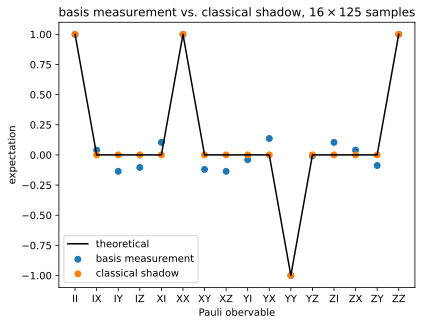

In [41]:
import matplotlib.pyplot as plt
xdata = list(th_results.keys())
ythdata = list(th_results.values())
ymdata = [results[k] for k in xdata]
ycsdata = [S_results[k] for k in xdata]
plt.plot(xdata, ythdata, c='black', label='theoretical')
plt.scatter(xdata, ymdata, label='basis measurement')
plt.scatter(xdata, ycsdata, label='classical shadow')
plt.legend()
plt.xlabel('Pauli obervable')
plt.ylabel('expectation')
plt.title(r'basis measurement vs. classical shadow, $16 \times 125$ samples')
plt.savefig('output/fig2.png', dpi=240)
plt.show()